# Difference Verification with Conditions

This notebook shows the experimental evaluation of difference verification,
as reported in our submission "Difference Verification with Conditions" to SEFM'20.

It is licensed under Apache 2.0 with copyright by Dirk Beyer (https://sosy-lab.org)
and part of https://gitlab.com/sosy-lab/research/data/difference-data .

We support the following claims:

* **Claim 1**:
Difference verification with conditions can be more effective than a full verification. 
Evaluation plan: For each verifier,
compare number of tasks solved by verifier vs. difference verifier 

* **Claim 2**:
Difference verification is more
effective when using multiple verifiers.
Evaluation plan: Compare number of tasks solved
by single verifiers vs. union of tasks solved by each verifier.

* **Claim 3**: 
Difference verification can be more efficient than pure verification.
Evaluation plan: Compare CPU time per task
for all tasks correctly solved by both plain verifier and difference verifier.

* **Claim 4**:
Runtime of difference verification is dominated by verifier.  
Evaluation plan: Relate time for verification
to time required by DiffCond + reducer.

* **Claim 5**:
Difference verification can complement existing incremental approaches.  
Evaluation plan: Compare difference verification
with results of precision reuse.

* **Claim 6**: Combination of difference verification and other incremental verification approaches can be beneficial.  
Evaluation plan: Compare results of difference verification with results of combination with precision reuse.


### Requirements

Requirements:

- python >= 3.6.9
- texlive >= 2017

Python plugins used:
- matplotlib >= 3.2
- benchexec >= 2.6
- pandas >= 1.03

These can be installed, for example, with `pip`.

### Usage
To run the code cells, select them and press `Shift+Enter`. Selection will automatically jump to the next cell.

To get more information about using Jupyter Notebooks, see [this introduction](https://dev.to/lembergerth/an-introduction-to-using-jupyter-notebooks-4hig).

In [1]:
from pathlib import Path
from collections import namedtuple
import math
import os
from benchexec import tablegenerator
import benchexec.result
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, NullLocator
from matplotlib import rc
rc('font',**{'family': 'sans-serif', 'size': 16})
## Uncomment this to use LaTeX font rendering (requires
## latex installation)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}\usepackage{bm}')

suffix = 'pdf'

*Important for offline-use*:
This notebook expects that you have run all experiments with the provided Makefile (`make all`) and that the files are available as listed below. Since running all experiments takes a large amount of time, the following links our own data if directory `data_raw` does not exist yet:

In [2]:
try:
    os.symlink('data-submission', 'data_raw', target_is_directory=True)
except FileExistsError:
    pass

This data that we used for the below analyses can also be found in [directory `data-submission/`](https://gitlab.com/sosy-lab/research/papers/differential-data/-/tree/master/data-submission).
Predicates that we used for precision reuse (Claims 5 + 6) can be found in [directory `precisions/`](https://gitlab.com/sosy-lab/research/papers/differential-data/-/tree/master/precisions).

In [3]:
COMBO_SETS = ('eca-token_ring', 'gcd-newton', 'pals-eca', 'pcsfifo-token_ring', 'square_softfloat')

RESULT_FILES = {
    'predicate-full': [
        Path(f'data_raw/predicate-combos-{s}.fullAnalysis.2020-02-29_0001.results.fullAnalysis.xml.bz2')
        for s in COMBO_SETS
    ],
    'cpa-seq-full': [
        Path(f'data_raw/cpa-seq-{s}.full.2020-02-29_0001.results.full.xml.bz2')
        for s in COMBO_SETS
    ],
    'uautomizer-full': [
        Path(f'data_raw/uautomizer-{s}.full.2020-02-29_0001.results.full.xml.bz2')
        for s in COMBO_SETS
    ],
    'predicate-diff': [
        Path(f'data_raw/predicate-combos-{s}.diffAnalysis-ignoreDecl.2020-02-29_0001.results.diffAnalysis-ignoreDecl.xml.bz2')
        for s in COMBO_SETS
    ],
    'diffProgram-generation': [
        Path(f'data_raw/predicate-combos-{s}.diffProgram-ignoreDecl.2020-02-29_0001.results.diffProgram-ignoreDecl.xml.bz2')
        for s in COMBO_SETS
    ],
    'cpa-seq-diff': [
        Path(f'data_raw/cpa-seq-{s}.residuals-ignored.2020-02-29_0001.results.residuals-ignored.xml.bz2')
        for s in COMBO_SETS
    ],
    'uautomizer-diff': [
        Path(f'data_raw/uautomizer-{s}.residuals-ignored.2020-02-29_0001.results.residuals-ignored.xml.bz2')
        for s in COMBO_SETS
    ],
    'precision-creation': [
        Path(f'data_raw/predicate-init-prec-{s}.2020-02-29_0001.results.xml.bz2')
        for s in COMBO_SETS
    ],
    'precision-reuse (predicate)': [
        Path(f'data_raw/predicate-combos-prec-{s}.fullAnalysis.2020-02-29_0001.results.fullAnalysis.xml.bz2')
        for s in COMBO_SETS
    ],
    'precision-reuse-diff (predicate)': [
        Path(f'data_raw/predicate-combos-prec-{s}.diffAnalysis-ignoreDecl.2020-02-29_0001.results.diffAnalysis-ignoreDecl.xml.bz2')
        for s in COMBO_SETS
    ],
}

In [4]:
# Creation of benchmark sets:
#for r, s in RESULT_FILES.items():
#    print(f"<union title=\"{r}\">")
#    for p in s:
#        print(f"  <result filename=\"../{str(p)}\" />")
#    print("</union>")

In [5]:
# this cell contains some boring utility methods that are used in the remainder of the analysis
from typing import List

TABLE_DEF_DIR = Path('table_defs')
assert TABLE_DEF_DIR.exists()

CORRECT = benchexec.result.CATEGORY_CORRECT
WRONG = benchexec.result.CATEGORY_WRONG
ERROR = benchexec.result.CATEGORY_ERROR

Dataset = namedtuple('Data', ('name', 'data'))

def _load_data(table_def_file: Path, data_files=()):
    parser = tablegenerator.create_argument_parser()
    options = parser.parse_args(["-x", str(table_def_file), *data_files])
    table_definition = tablegenerator.parse_table_definition_file(table_def_file)
    if data_files:
        return list(tablegenerator.load_results_with_table_definition(data_files, table_definition, table_def_file, options))
    return list(tablegenerator.load_results_from_table_definition(table_definition, table_def_file, options))


def _get_benchmarkname(result_set):
    return tuple(result_set.attributes['benchmarkname'])


def _to_value(possible_val, column):
    if column.is_numeric() and possible_val is not None:
        unit_len = len(column.unit)
        return float(possible_val[:-unit_len])
    return possible_val


def _get_values(result_set):
    def task_name(r):
        return '/'.join(r.task_id[0].split('/')[-2:])
    
    def cast_values(r):
        return [_to_value(val, col) for val, col in zip(r.values, r.columns)]
    
    return [[task_name(r), r.category] + cast_values(r) for r in result_set.results]


def _get_column_titles(result_set):
    return ['task_id', 'category'] + [col.title for col in result_set.columns]


def get_data(table_def_file: Path, data_files=()) -> List[pd.DataFrame]:
    raw_data = _load_data(table_def_file, data_files)
    return [
        Dataset(name=_get_benchmarkname(result_set),
                data=pd.DataFrame(data=_get_values(result_set), columns=_get_column_titles(result_set)))
        for result_set in raw_data
            ]


def clean_dataset(*datasets):
    """Filters dataset by result: Returns new dataframe that has cpu-time >=900 for each unsolved result."""
    def is_timeout(d):
        return d.category == ERROR and d.status.startswith('TIMEOUT')
    
    def is_correct(d):
        return d.category == CORRECT
    per_rows = zip(*(ds.iterrows() for ds in datasets))
    mask = [not all(is_correct(d[1]) or is_timeout(d[1]) for d in row) for row in per_rows]
    d = list()
    for dataset in datasets:
        df = dataset.copy()
        df.loc[mask, 'cputime'] = 900
        d.append(df)
    return d


def remove_incomplete_rows(datasets: list):
    def _get_common_tasks(datasets):
        common_tasks = None
        for df in [d.data for d in datasets]:
            if common_tasks is None:
                common_tasks = set(df['task_id'])
            else:
                common_tasks = common_tasks.intersection(set(df['task_id']))
        return common_tasks
    common_tasks = _get_common_tasks(datasets)
    new_datasets = list()
    for d in datasets:
        mask = d.data.task_id.isin(common_tasks)
        new_df = d.data[mask]
        new_datasets.append(Dataset(d[0], new_df))
        
    return new_datasets
    

def get_proves(df):
    return df[df.status.str.startswith('true')]


def get_alarms(df):
    return df[df.status.str.startswith('false')]


def get_correct(df):
    return df[(df.filter(like='category') == CORRECT).any(axis=1)]


def get_incorrect(df):
    return df[(df.filter(like='category') == WRONG).any(axis=1) & (df.filter(like='category') != CORRECT).all(axis=1)]
    
    
def get_unknown(df):
    return df[((df.filter(like='category') == benchexec.result.CATEGORY_UNKNOWN)
              | (df.filter(like='category') == benchexec.result.CATEGORY_MISSING)
              | (df.filter(like='category') == benchexec.result.CATEGORY_ERROR)).all(axis=1)]
    
    
def get_correct_proves(df):
    return get_correct(get_proves(df))


def get_correct_alarms(df):
    return get_correct(get_alarms(df))


def get_incorrect_proves(df):
    return get_incorrect(get_proves(df))


def get_incorrect_alarms(df):
    return get_incorrect(get_alarms(df))


def to_sig_digits(s, digits):
    if isinstance(s, (int, float)):
        return round(s, -int(math.floor(math.log10(abs(s)))) + (digits - 1))
    elif isinstance(s, pd.Series):
        return s.map(lambda x: to_sig_digits(x, digits))
    return [to_sig_digits(x, digits) for x in s]


def from_kb_to_mb(s):
    if isinstance(s, (int, float)):
        return s / 1000
    elif isinstance(s, pd.Series):
        return s.map(from_kb_to_mb)
    else:
        return [from_kb_to_mb(x) for x in s]

    
def style_table(df, sig_digits=2):
    def color_correct(s):
        return ['color: green' if v == 'correct' else '' for v in s]
    def color_incorrect(s):
        return ['color: red' if v == benchexec.result.CATEGORY_WRONG else '' for v in s]
    def color_unknown(s):
        return ['color: violet' if v != 'correct' and v != benchexec.result.CATEGORY_WRONG else '' for v in s]
    to_show = df.copy()
    to_show.cputime = to_sig_digits(to_show.cputime, digits=sig_digits)
    to_show.walltime = to_sig_digits(to_show.walltime, digits=sig_digits)
    to_show.memory = to_sig_digits(to_show.memory, digits=sig_digits)
    to_show.memory = from_kb_to_mb(to_show.memory)
    styler = to_show.style.apply(color_correct, subset=['category'])
    styler = styler.apply(color_incorrect, subset=['category'])
    styler = styler.apply(color_unknown, subset=['category'])
    return styler


def create_scatter_plot(x_data, y_data, xlabel="", ylabel="", xlim=900, ylim=900, scale='log', target_file=None, helper_line=True):
    plt.clf()
    ax = plt.gca()
    ax.set_xlabel(xlabel, labelpad=10)
    ax.set_ylabel(ylabel, labelpad=10)
    if scale == 'log':
        ax.set_xlim(0.5, xlim * 1.1)
        ax.set_ylim(0.5, ylim * 1.1)
        ax.spines['left'].set_bounds(low=1, high=ylim)
        ax.spines['bottom'].set_bounds(low=1, high=xlim)
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.set_xlim(-int(xlim * 0.1), xlim * 1.1)
        ax.set_ylim(-int(ylim * 0.1), ylim * 1.1)
        ax.spines['left'].set_bounds(low=0, high=ylim)
        ax.spines['bottom'].set_bounds(low=0, high=xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_locator(NullLocator())
    if scale == "log":
        ax.set_xticks([1, int(xlim / 10), xlim])
        ax.set_yticks([1, int(ylim / 10), ylim])
    else:
        ax.set_xticks([0, int(xlim / 2), xlim])
        ax.set_yticks([0, int(ylim / 2), ylim])

    ax.set_aspect('equal')
    plt.gcf().set_size_inches(3.5, 3.5)

    if helper_line:
        plt.plot(range(0, xlim), range(0, ylim), '-k', alpha=0.3)
        if scale == 'log':
            plt.plot(range(0, int(xlim / 10)), range(0, ylim, 10), '-k', alpha=0.4)
            plt.plot(range(0, xlim, 10), range(0, int(ylim / 10)), '-k', alpha=0.4)
    ax.scatter(x_data, y_data, marker='+', edgecolors='blue', linewidth=1, facecolors='blue')

    plt.tight_layout()
    if target_file:
        plt.savefig(target_file, dpi=150)
        return plt
    return plt


In [6]:
# All data used - is loaded later
necessary_runs = ('predicate-full', 'cpa-seq-full', 'uautomizer-full', 'predicate-diff', 'diffProgram-generation', 'cpa-seq-diff', 'uautomizer-diff', 'precision-creation', 'precision-reuse (predicate)', 'precision-reuse-diff (predicate)')
assert all(path.exists() for s in necessary_runs for path in RESULT_FILES[s]), f"Missing: {[p for s in necessary_runs for p in RESULT_FILES[s] if not p.exists()]}"

# Experiment-specific modifications to input data: Use same task_id for runs on residual program
# and original program, remove data with missing runs
def get_prepared_data(table_def, run_names=necessary_runs):
    data = get_data(table_def)
    # unify task_ids by using basename
    for d in data:
        df = d.data
        df.task_id = df.task_id.str.split(pat='/', expand=True).loc[:, 1]
    data = remove_incomplete_rows(data)
    return {
        name: d
        for name, d in
        zip(run_names, data)
    }

#### Claim 1 + 2 (Effectiveness of difference verification vs. full verification)

##### Table 1

Table 1 compares the results for the used analyses. It shows that difference verifiers can solve
tasks that the original verifiers can not solve (Claim 1), and that the union of difference verifiers can solve more tasks than each difference verifier alone (Claim 2).

In [7]:
# Define and read in data  per category:

CategorySet = namedtuple('CategorySet', ('name', 'table_def'))
all_data_per_set = {
    CategorySet('eca+token', 'eca-token.xml'): None,
    CategorySet('gcd+newton', 'gcd-newton.xml'): None,
    CategorySet('pals+eca', 'pals-eca.xml'): None,
    CategorySet('sfifo+token', 'sfifo-token.xml'): None,
    CategorySet('square+softflt', 'square-softflt.xml'): None,
}
for k in all_data_per_set:
    def_name = k.table_def
    table_def = TABLE_DEF_DIR / def_name
    all_data_per_set[k] = get_prepared_data(table_def)

In [8]:
VERIFIERS = ('predicate-diff', 'predicate-full', 'cpa-seq-diff', 'cpa-seq-full', 'uautomizer-diff', 'uautomizer-full')

final_df = dict()
columns = list()

# Table 1 does not include category 'ssh' because every verifier can solve all its tasks
data_per_set = {k: v for k,v in all_data_per_set.items()}

def get_empty_dict_for_category(category_info):
    return {'category_name': category_info.name, 'correct_proves': None, 'correct_alarms': None, 'distinct': None, 'unsolved': None}

for name, table_def in data_per_set: 
    columns.append(name)
    
num_tasks = list()
for k, data in data_per_set.items():
    num_tasks.append(len(data['predicate-diff'].data))

# Results per verifier
for verifier in VERIFIERS:
    final_df[verifier] = list()
    for info, category_set in data_per_set.items():
        new_df = get_empty_dict_for_category(info)
        df = category_set[verifier].data
        new_df['correct_proves'] = len(get_correct_proves(df))
        new_df['correct_alarms'] = len(get_correct_alarms(df))
        new_df['unsolved'] = len(get_unknown(df))+ len(get_incorrect(df))
        final_df[verifier].append(new_df)

## Results for 'All-results':    
def get_union(category_set, verifiers):
    df_all = [category_set[v].data for v in verifiers]
    df = pd.merge(df_all[0], df_all[1], on="task_id", suffixes=("_1", "_2"))
    for idx, n in enumerate(df_all[2:], 3):
        df = pd.merge(df, n, on="task_id", suffixes=(f"_{idx-1}", f"_{idx}"))
    return df

def get_rows_union(*verifiers):
    final_df = list()
    for info, category_set in data_per_set.items():
        new_df = get_empty_dict_for_category(info)
        df = get_union(category_set, verifiers)
        correct = get_correct(df)
        new_df['correct_proves'] = len(correct[~correct.task_id.str.contains('false-unreach')])
        new_df['correct_alarms'] = len(correct[correct.task_id.str.contains('false-unreach')])
        new_df['unsolved'] = len(get_unknown(df))+ len(get_incorrect(df))
        final_df.append(new_df)
    return final_df

final_df[r'All$^\Delta$'] = get_rows_union('predicate-diff', 'cpa-seq-diff', 'uautomizer-diff')
final_df[r'All'] = get_rows_union('predicate-full', 'cpa-seq-full', 'uautomizer-full')

# Distinct results of difference verifiers
ALL_DIFFS = ('predicate-diff', 'cpa-seq-diff', 'uautomizer-diff')
ALL_FULL = ('predicate-full', 'cpa-seq-full', 'uautomizer-full')
for diff, full in zip(ALL_DIFFS, ALL_FULL):
    for idx, category_set in enumerate(data_per_set.values()):
        join = pd.merge(category_set[full].data, category_set[diff].data, on='task_id', suffixes=('_full', '_diff'))
        mask = (join.category_full != CORRECT) & (join.category_diff == CORRECT)
        final_df[diff][idx]['distinct'] = len(join[mask])
        
# Distinct results of all diff. vs. all full
for idx, (_, category_set) in enumerate(data_per_set.items()):
        df_diff = get_union(category_set, ALL_DIFFS)
        df_full = get_union(category_set, ALL_FULL)
        join = pd.merge(df_full, df_diff, on='task_id', suffixes=('_full', '_diff'))
        mask = (join.filter(regex=r'category.*_full') != CORRECT).all(axis=1) & (join.filter(regex=r'category.*_diff') == CORRECT).any(axis=1)
        final_df[r'All$^\Delta$'][idx]['distinct'] = len(join[mask])

In [9]:
f"Number of tasks: {sum(num_tasks)}"

'Number of tasks: 10426'

In [10]:
def concat_final_df(final_df):
    frames = list()
    for idx, cat in enumerate(data_per_set):
        df = pd.DataFrame.from_dict({k2: {k: v[idx][k2] for k, v in final_df.items()} for d in final_df.values() for k2, v2 in d[idx].items()})
        frames.append(df)
    full_df = pd.concat(frames, axis=1)
    return full_df
concat_final_df(final_df)

category_name  correct_proves  correct_alarms  distinct  \
predicate-diff      eca+token            1447             999     451.0   
predicate-full      eca+token            1080             944       NaN   
cpa-seq-diff        eca+token             966             671     350.0   
cpa-seq-full        eca+token             755            1268       NaN   
uautomizer-diff     eca+token             270             260     270.0   
uautomizer-full     eca+token               0             325       NaN   
All$^\Delta$        eca+token            1527             999     448.0   
All                 eca+token            1080            1295       NaN   

                 unsolved category_name  correct_proves  correct_alarms  \
predicate-diff       1194    gcd+newton              48             572   
predicate-full       1616    gcd+newton               0             572   
cpa-seq-diff         2003    gcd+newton              48             572   
cpa-seq-full         1617    gcd+newton               0             572   
uautomizer-diff      3110    gcd+newton              16               0   
uautomizer-full      3315    gcd+newton               0             520   
All$^\Delta$         1114    gcd+newton              48             572   
All                  1265    gcd+newton               0             572   

                 distinct  unsolved  ... category_name  correct_proves  \
predicate-diff       48.0      1304  ...   sfifo+token             655   
predicate-full        NaN      1352  ...   sfifo+token             558   
cpa-seq-diff         48.0      1304  ...   sfifo+token             480   
cpa-seq-full          NaN      1352  ...   sfifo+token             372   
uautomizer-diff      16.0      1908  ...   sfifo+token             349   
uautomizer-full       NaN      1404  ...   sfifo+token             341   
All$^\Delta$         48.0      1304  ...   sfifo+token             655   
All                   NaN      1352  ...   sfifo+token             558   

                 correct_alarms  distinct  unsolved   category_name  \
predicate-diff              494      98.0       723  square+softflt   
predicate-full              507       NaN       807  square+softflt   
cpa-seq-diff                390     108.0      1002  square+softflt   
cpa-seq-full                619       NaN       881  square+softflt   
uautomizer-diff             234     112.0      1289  square+softflt   
uautomizer-full             258       NaN      1273  square+softflt   
All$^\Delta$                494      98.0       723  square+softflt   
All                         626       NaN       688  square+softflt   

                 correct_proves  correct_alarms  distinct  unsolved  
predicate-diff               81              75      70.0        84  
predicate-full               33              53       NaN       154  
cpa-seq-diff                 61              69      61.0       110  
cpa-seq-full                  0              75       NaN       165  
uautomizer-diff              61              45      49.0       134  
uautomizer-full              44              57       NaN       139  
All$^\Delta$                 81              75      40.0        84  
All                          55              75       NaN       110  

[8 rows x 25 columns]

Latex table, as used in paper:

In [11]:
NAME_MAP = {
    'predicate-diff': r'\predicatediff',
    'predicate-full': r'\predicate',
    'cpa-seq-diff': r'\cpaseqdiff',
    'cpa-seq-full': r'\cpaseq',
    'uautomizer-diff': r'\uautomizerdiff',
    'uautomizer-full': r'\uautomizer',
}

COLUMNS = ('correct_proves', 'correct_alarms', 'distinct', 'unsolved')

print(r"\begin{tabular}{l | S[table-format=4] S[table-format=4] S[table-format=3] S[table-format=4] | S[table-format=2] S[table-format=3] S[table-format=2] S[table-format=4]| S[table-format=2] S[table-format=1] S[table-format=2] S[table-format=3]| S[table-format=3] S[table-format=3] S[table-format=3] S[table-format=4]| S[table-format=2] S[table-format=2] S[table-format=2.0]S[table-format=3.0]}")
print(r"  \toprule")
header = r" "
for name in columns[:-1]:
    header += r" & \multicolumn{4}{c|}{" + name + r"}"
header += r" & \multicolumn{4}{c}{" + columns[-1] + r"}"
header += r" \\"
print(header)
header = r" "
for n in num_tasks[:-1]:
    header += r" & \multicolumn{4}{c|}{(\num{" + str(n) + r"})}"
header += r" & \multicolumn{4}{c}{(\num{" + str(num_tasks[-1]) + r"})}"
header += r" \\"
print(header)
print(r"    & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP\\")

for verifier in VERIFIERS:
    name = NAME_MAP[verifier]
    row = [name]
    for i in final_df[verifier]:
        for c in COLUMNS:
            if i[c] is not None:
                row += [str(i[c])]
            else:
                row += ['']
    print(" " + " & ".join(row) + r" \\")

print(r"  \midrule")

for verifier in (r'All$^\Delta$', 'All'):
    row = [verifier]
    for i in final_df[verifier]:
        for c in COLUMNS:
            if i[c] is not None:
                row += [str(i[c])]
            else:
                row += ['']
    print("  " + " & ".join(row) + r" \\")

print(r"  \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{l | S[table-format=4] S[table-format=4] S[table-format=3] S[table-format=4] | S[table-format=2] S[table-format=3] S[table-format=2] S[table-format=4]| S[table-format=2] S[table-format=1] S[table-format=2] S[table-format=3]| S[table-format=3] S[table-format=3] S[table-format=3] S[table-format=4]| S[table-format=2] S[table-format=2] S[table-format=2.0]S[table-format=3.0]}
  \toprule
  & \multicolumn{4}{c|}{eca+token} & \multicolumn{4}{c|}{gcd+newton} & \multicolumn{4}{c|}{pals+eca} & \multicolumn{4}{c|}{sfifo+token} & \multicolumn{4}{c}{square+softflt} \\
  & \multicolumn{4}{c|}{(\num{3640})} & \multicolumn{4}{c|}{(\num{1924})} & \multicolumn{4}{c|}{(\num{2750})} & \multicolumn{4}{c|}{(\num{1872})} & \multicolumn{4}{c}{(\num{240})} \\
    & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP & \OK & \FAIL & \SOLE & \IMP\\
 \predicatediff & 1447 & 999 & 451 & 1194 & 48 & 572 & 48 & 1304 & 15 & 55 & 20 & 2680 & 6

#### Claim 3 (Efficiency of difference verification vs. full verification)

##### Fig. 7abc

Figures 7a, 7b and 7c compare the CPU time (in seconds) of full verification and difference verification per task,
for predicate analysis, CPA-Seq, and UAutomizer.

In [12]:
# Overwrite data_per_set to include all categories, even 'ssh'
data_per_set = all_data_per_set
concat_data = {v: pd.concat([r[v].data for r in data_per_set.values()]) for v in necessary_runs}

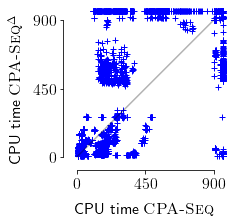

In [13]:
NAME_MAP = {
    'predicate-diff': r'\scshape Predicate$^\Delta$',
    'predicate-full': r'\scshape Predicate',
    'cpa-seq-diff': r'\scshape CPA-Seq$^\Delta$',
    'cpa-seq-full': r'\scshape CPA-Seq',
    'uautomizer-diff': r'\scshape UAutomizer$^\Delta$',
    'uautomizer-full': r'\scshape UAutomizer',
}
for diff, full in zip(('cpa-seq-diff', 'uautomizer-diff', 'predicate-diff'), ('cpa-seq-full', 'uautomizer-full', 'predicate-full')):
    # set all non-successful tasks to 900s cputime
    x_data, y_data = clean_dataset(concat_data[full], concat_data[diff])
    x_data = x_data
    y_data = y_data

    name_full = NAME_MAP[full]
    name_diff = NAME_MAP[diff]
    
    p = create_scatter_plot(x_data.cputime,
                            y_data.cputime,
                            scale='linear',
                            xlabel=f"CPU time {name_full}",
                            ylabel=f"CPU time {name_diff}",
                            target_file=f"results_processed/{full}-vs-{diff}.{suffix}",
                            )
    p.show()

#### Claim 4 (Verifier dominates runtime)

##### Fig. 8a
The scatter plot below (Figure 8a) shows that the runtime of algorithm *DiffCond* and the reducer (diff. components) is negligible compared to the runtime of the verifier.

In [14]:
diffcond = 'diffProgram-generation'

# Commented code takes minimum of the two verifiers for comparison.
#if False:
#    m = pd.merge(concat_data['cpa-seq-diff'], concat_data['uautomizer-diff'], on="task_id", suffixes=("_1", "_2")) 
#    m['cputime'] = m[['cputime_1', 'cputime_2']].min(axis = 1)
#else:
x = pd.concat([concat_data['cpa-seq-diff'], concat_data['uautomizer-diff']])
y = pd.concat([concat_data[diffcond], concat_data[diffcond]])
x_data, y_data = clean_dataset(x)[0], y
#rc('font',**{'family': 'sans-serif', 'size': 14})
p = create_scatter_plot(x_data.cputime,
                    y_data.cputime,
                    scale='linear',
                    xlabel="CPU time verification",
                    ylabel="CPU time diff.\ components",
                    target_file=f"results_processed/overhead.{suffix}",
                    helper_line=False)
p.show()

In [15]:
d = concat_data[diffcond].cputime
print(f"Minimum time required by diffCond+reducer: {d.min()}")
print(f"Maximum time required by diffCond+reducer: {d.max()}")
print(f"Median of CPU time required by diffCond+reducer: {d.median()}")
print(f"Mean of CPU time required by diffCond+reducer: {d.mean()}")

Minimum time required by diffCond+reducer: 5.286095202
Maximum time required by diffCond+reducer: 41.635694989
Median of CPU time required by diffCond+reducer: 20.054950585
Mean of CPU time required by diffCond+reducer: 19.461891665822847


#### Claim 5 (Difference verification complements existing approaches)

##### Fig 8b
The scatter plot below (Figure 8b) shows the CPU time (in seconds) per task for incremental verification with precision reuse
and incremental verification with difference verification.

In [16]:
diff = 'predicate-diff'
reuse = 'precision-reuse (predicate)'

x_data, y_data = clean_dataset(concat_data[reuse], concat_data[diff])
#rc('font',**{'family': 'sans-serif', 'size': 14})
p = create_scatter_plot(x_data.cputime,
                    y_data.cputime,
                    scale='linear',
                    xlabel=r"CPU time \scshape Predicate$^{\bm\circlearrowright}$",
                    ylabel=r"CPU time \scshape Predicate$^\Delta$",
                    target_file=f"results_processed/diffVsPrec.{suffix}")
p.show()

#### Claim 6 (Combination of incremental approaches beneficial)

The table shown below compares the results for difference verification with predicate analysis, predicate analysis with precision reuse,
and the combination of both approaches.
Column 'distinct' shows the distinct results of the combination of both approaches for each category.

In [17]:
diff = 'predicate-diff'
reuse_combo = 'precision-reuse-diff (predicate)'
reuse = 'precision-reuse (predicate)'

final_df = dict()
for verifier in (diff, reuse, reuse_combo):
    final_df[verifier] = list()
    for info, category_set in data_per_set.items():
        new_df = get_empty_dict_for_category(info)
        df = category_set[verifier].data
        new_df['correct_proves'] = len(get_correct_proves(df))
        new_df['correct_alarms'] = len(get_correct_alarms(df))
        new_df['unsolved'] = len(get_unknown(df))+ len(get_incorrect(df))
        final_df[verifier].append(new_df)
   
for idx, category_set in enumerate(data_per_set.values()):
    join = pd.merge(category_set[diff].data, category_set[reuse_combo].data, on='task_id', suffixes=('_diff', '_combo'))
    mask = (join.category_diff != CORRECT) & (join.category_combo == CORRECT)
    final_df[reuse_combo][idx]['distinct'] = len(join[mask])

concat_final_df(final_df)

category_name  correct_proves  \
predicate-diff                       eca+token            1447   
precision-reuse (predicate)          eca+token            1080   
precision-reuse-diff (predicate)     eca+token            1447   

                                  correct_alarms  distinct  unsolved  \
predicate-diff                               999       NaN      1194   
precision-reuse (predicate)                  944       NaN      1616   
precision-reuse-diff (predicate)            1004      17.0      1189   

                                 category_name  correct_proves  \
predicate-diff                      gcd+newton              48   
precision-reuse (predicate)         gcd+newton               0   
precision-reuse-diff (predicate)    gcd+newton              48   

                                  correct_alarms  distinct  unsolved  ...  \
predicate-diff                               572       NaN      1304  ...   
precision-reuse (predicate)                  572       NaN      1352  ...   
precision-reuse-diff (predicate)             572       0.0      1304  ...   

                                 category_name  correct_proves  \
predicate-diff                     sfifo+token             655   
precision-reuse (predicate)        sfifo+token             558   
precision-reuse-diff (predicate)   sfifo+token             651   

                                  correct_alarms  distinct  unsolved  \
predicate-diff                               494       NaN       723   
precision-reuse (predicate)                  507       NaN       807   
precision-reuse-diff (predicate)             498      12.0       723   

                                   category_name  correct_proves  \
predicate-diff                    square+softflt              81   
precision-reuse (predicate)       square+softflt              33   
precision-reuse-diff (predicate)  square+softflt              81   

                                  correct_alarms  distinct  unsolved  
predicate-diff                                75       NaN        84  
precision-reuse (predicate)                   51       NaN       156  
precision-reuse-diff (predicate)              75       0.0        84  

[3 rows x 25 columns]

In [18]:
sum_distinct = sum(c['distinct'] for c in final_df[reuse_combo])
print(f"Distinct results that can only be solved by combination of diff. verification and precision reuse: {sum_distinct}")
print("Latex command: ")
print(r"\newcommand{\NumDiffComboDistinct}{\num{" + str(sum_distinct) + r"}}")

Distinct results that can only be solved by combination of diff. verification and precision reuse: 29
Latex command: 
\newcommand{\NumDiffComboDistinct}{\num{29}}


##### Fig. 8c

The scatter plot below (Figure 8c) shows the CPU time (in seconds) per task for incremental verification with difference verification,
and incremental verification with difference verification **and** precision reuse.

In [19]:
diff = 'predicate-diff'
reuse_combo = 'precision-reuse-diff (predicate)'
reuse = 'precision-reuse (predicate)'

x_data, y_data = clean_dataset(concat_data[diff], concat_data[reuse_combo])
#rc('font',**{'family': 'sans-serif', 'size': 14})
p = create_scatter_plot(x_data.cputime,
                    y_data.cputime,
                    scale='linear',
                    xlabel=r"CPU time \scshape Predicate$^{\Delta}$",
                    ylabel=r"CPU time \scshape Predicate$^{\Delta\bm\circlearrowright}$",
                    target_file=f"results_processed/diffVsCombi.{suffix}")
p.show()

Not included in the publication, we can see that the performance difference between
precision reuse and the combination of difference verification and precision reuse
is very similar to the performance difference between precision reuse and difference verification (without precision reuse):


In [20]:
x_data, y_data = clean_dataset(concat_data[reuse], concat_data[reuse_combo])
#rc('font',**{'family': 'sans-serif', 'size': 14})
p = create_scatter_plot(x_data.cputime,
                    y_data.cputime,
                    scale='linear',
                    xlabel=r"CPU time \scshape Predicate$^{\bm\circlearrowright}$",
                    ylabel=r"CPU time \scshape Predicate$^{\Delta\bm\circlearrowright}$")
p.show()